## Description：
This notebook tries to implement the original ItemCF method. The data set used is the Montréal data set in the Yelp data set, and the reviews part of the data set is mainly used because it contains the user's rating of the business. The code is mainly divided into the following steps：
1. Import the yelp data set, filter the data set and divide it into training set and test set.
2. Make 5 recommendations by using training set, and each recommendation generates a recommendation list for the first 200 users in the training set.
3. Calculate the PRU.

In [51]:
import os
import time

import json

from operator import itemgetter

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import random

## Load Json data

In [52]:
def read_josn (path):
    file = open(path, "r", encoding = 'utf-8')
    df = []
    for line in file.readlines():
        dic = json.loads(line)
        df.append(dic)
    return df

In [4]:
# load business data
path = "data/Montréal_Data/Montréal_business.json"
business_list = read_josn(path)
# load reviews data
path = "data/Montréal_Data/Montréal_Review.json"
review_list = read_josn(path)
# load user data
path = "data/Montréal_Data/Montréal_User.json"
user_list = read_josn(path)

## Transform Json to dataframe

In [53]:
# business list into dataframe
df_business = pd.DataFrame()
business_id = []
name = []
for element in business_list:
    business_id.append(element["business_id"])
    name.append(element["name"])

Business_Num_Id = {}
U = 1
B = 1
Business_Id = []
for index in range(len(business_id)):
    if business_id[index] not in Business_Num_Id.keys():
        Business_Num_Id[business_id[index]] = B
        B = B + 1
    Business_Id.append(Business_Num_Id[business_id[index]])
    

df_business["RawBusinessId"] = business_id
df_business["businessId"] = Business_Id
df_business["title"] = name

df_business.head()

,RawBusinessId,businessId,title
0,i_oghUPqLzzJtxC6Zm-D2A,1,Braseiro
1,735UkyT4px_oeW3iyotGmA,2,Parc-nature de l'Île-de-la-Visitation
2,SWX0K1dpy4fcRq-ktZxmCg,3,Bistro des Moulins
3,spi9UEWyNrq2O4y5DD84LA,4,Restaurant Nhu Y
4,cBQDYO0dIpG6--I3DMiWoQ,5,Secrets de Femme


In [54]:
# User list into dataframe
df_user = pd.DataFrame()
user_id = []
name = []
for element in user_list:
    user_id.append(element["user_id"])
    name.append(element["name"])

User_Num_Id = {}
U = 1
User_Id = []
for index in range(len(user_id)):
    if user_id[index] not in User_Num_Id.keys():
        User_Num_Id[user_id[index]] = U
        U = U + 1
    User_Id.append(User_Num_Id[user_id[index]])
    
df_user["RawUserId"] = user_id
df_user["UserId"] = User_Id
df_user["name"] = name

df_user.head()

,RawUserId,UserId,name
0,jx-BchSqX2PlnMflR62Urw,1,Jack
1,4TCOItk-gIJROyNA5ftZ-Q,2,Alma
2,i7dva-DqwjyAtLVc2idhNA,3,Pradeep
3,U4INQZOPSUaj8hMjLlZ3KA,4,Michael
4,B4GZ3kX1TpxJUCkpPqYqng,5,Vivian


In [55]:
# review list into dataframe
df_ratings = pd.DataFrame()
#review_id = []
user_id = []
business_id = []
ratings = []
for element in review_list:
    uid = User_Num_Id[element["user_id"]]
    bid = Business_Num_Id[element["business_id"]]
    
    user_id.append(uid)
    business_id.append(bid)
    ratings.append(element["stars"])

#df_ratings["review_id"] = review_id
df_ratings["userId"] = user_id
df_ratings["businessId"] = business_id
df_ratings["rating"] = ratings

df_ratings.head()

,userId,businessId,rating
0,579,604,3.0
1,5400,91,4.0
2,1273,442,3.0
3,1202,478,5.0
4,3358,202,1.0


## Filter data
### For business

In [58]:
# get rating frequency
df_business_cnt = pd.DataFrame(df_ratings.groupby('businessId').size(), columns=['count'])
df_business_cnt.head()

,count
businessId,
1,22
2,10
3,3
4,11
5,3


In [59]:
# top quantiles of rating counts
df_business_cnt['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    2348.0
0.95      84.0
0.90      51.0
0.85      35.0
0.80      27.0
0.75      21.0
0.70      16.6
0.65      14.0
Name: count, dtype: float64

In [60]:
# filter data - movies count less than 20
popularity_thres = 10
popular_business = list(set(df_business_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_business = df_ratings[df_ratings.businessId.isin(popular_business)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular business: ', df_ratings_drop_business.shape)

shape of original ratings data:  (151238, 3)
shape of ratings data after dropping unpopular business:  (133714, 3)


### For users

In [61]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_business.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,2
2,11
3,49
4,20
5,4


In [62]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    617.0
0.95      9.0
0.90      5.0
0.85      4.0
0.80      3.0
0.75      3.0
0.70      2.0
0.65      2.0
0.60      2.0
0.55      1.0
Name: count, dtype: float64

In [63]:
# filter data
ratings_thres = 2
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_business[df_ratings_drop_business.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular business and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (151238, 3)
shape of ratings data after dropping both unpopular business and inactive users:  (108683, 3)


In [64]:
df_ratings_drop_users.index = list(range(0, df_ratings_drop_users.shape[0]))
df_ratings_drop_users

,userId,businessId,rating
0,579,604,3.0
1,5400,91,4.0
2,1273,442,3.0
3,1202,478,5.0
4,3358,202,1.0
...,...,...,...
108678,5720,5837,1.0
108679,27409,5821,5.0
108680,39378,6252,5.0
108681,20833,5912,5.0


In [65]:
print(len(np.unique(df_ratings_drop_users['userId'])))
print(len(np.unique(df_ratings_drop_users['businessId'])))

18614
2891


## Transform dataframe to dictionary

In [66]:
# Define 2 dictionaries, one is for training set, the other is for test set.
trainSet, testSet = {}, {}
trainSet_len, testSet_len = 0, 0
pivot = 0.75    # Propotion of training set.

# Traverse every row of data， store in the format as {businessId: {userId: rating}}.
for ele in df_ratings_drop_users.itertuples():
    user, business, rating = getattr(ele, 'userId'), getattr(ele, 'businessId'), getattr(ele, 'rating')
    if random.random() < pivot:
        trainSet.setdefault(business, {})
        trainSet[business][user] = rating
        trainSet_len += 1
    else:
        testSet.setdefault(business, {})
        testSet[business][user] = rating 
        testSet_len += 1

print('Split new trainingSet and new testSet success!')
print('TrainSet = %s' % trainSet_len)
print('TestSet = %s' % testSet_len)

Split new trainingSet and new testSet success!
TrainSet = 81625
TestSet = 27058


## Calculate the normalized popularity for each business:


In [67]:
# Calculate the norm popularity for each business, which is how many times each business is rated by users.
train_business_popular = {}
for m in trainSet.keys():
    if m not in train_business_popular.keys():
        train_business_popular[m] = len(trainSet[m])

# Normalize the popular.
max_pop = max(train_business_popular.values())
min_pop = min(train_business_popular.values())

for k in train_business_popular.keys():
    train_business_popular[k] = train_business_popular[k] / (max_pop - min_pop)
    if train_business_popular[k] > 1:
        train_business_popular[k] = 1

## Define the function to calculate the cosine similarity for businesses:

In [68]:
# Create business similarity matrix.
def get_business_sim_matrix(trainSet):

    print("Generating similarity matrix......")
    business_sim_matrix = {}
    for b1 in trainSet.keys():     
        for b2 in trainSet.keys():
            if b1 == b2:
                continue
            business_sim_matrix.setdefault(b1, {})      
            business_sim_matrix[b1].setdefault(b2, 0)
            u1 = list(trainSet[b1].keys())
            u2 = list(trainSet[b2].keys())
            u_intersect = list(set(u1) & set(u2))
            numerator = 0
            for u in u_intersect:
                numerator += trainSet[b1][u] * trainSet[b2][u]
            denominator = pow(sum(list(map(lambda x: x**2,  list(trainSet[b1].values())))), 0.5) * pow(sum(list(map(lambda x: x**2,  list(trainSet[b2].values())))), 0.5)
            business_sim_matrix[b1][b2] = numerator / denominator

    print("Similarity matrix has generated")
    return business_sim_matrix

## Define the function to generate the recommendation list to the aim user:

In [69]:
def recommend(aim_user, trainSet, sim_matrix, k=20, n=5):
    rank ={}
    rated_business = {}   

    # Get businesses that have been rated by the target user.
    for b in trainSet.keys():
        if aim_user in trainSet[b].keys():
            rated_business[b] = trainSet[b][aim_user]

    

    for business, rating in rated_business.items():
        # Traverse the top k businesses that are most similar to the current business, and obtain these businesses and similar scores.
        for related_business, w in sorted(sim_matrix[business].items(), key=itemgetter(1), reverse=True)[:k]:
            # If the business has been rated by the target user, skip it.
            if related_business in rated_business:
                continue

            # Calculate the user's preference value for related_movie, and initialize the value to 0.
            rank.setdefault(related_business, 0)
            # Multiply the preference value w of the item related_movie by its similar item and then sum it up.
            # Basis of ranking——> the similarity between the recommended business and the business that has been rated (cumulative) * the rating of the rated business.
            rank[related_business] += w * float(rating)

    # Generate the final recommendation list for the aim user.
    return sorted(rank.items(), key=itemgetter(1), reverse=True)[:n]  # itemgetter(1) 是简洁写法

## Do 5 recommendations:
1. Generate recommendation list to the first 200 users in the training set.
2. Draw a scatter plot of business popualrity against the recommendation frequency.
3. After recommendation, update the rating matrix by using the prediction ratings in the recommendation list. Also update the similarity matirx and the business popularity.
4. Go to step 1.

Generating similarity matrix......
Similarity matrix has generated
Graph 1 has been generated...
Generating similarity matrix......
Similarity matrix has generated
Graph 2 has been generated...
Generating similarity matrix......
Similarity matrix has generated
Graph 3 has been generated...
Generating similarity matrix......
Similarity matrix has generated
Graph 4 has been generated...
Generating similarity matrix......
Similarity matrix has generated
Graph 5 has been generated...


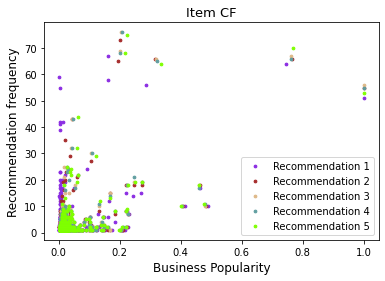

In [70]:
# Recommended 10 merchants per user for random 100 users
trainSet_temp = trainSet
# Calculate the popularity for each business, which is how many times each business is rated by users.
train_business_popular_temp = train_business_popular
col = list(colors.cnames.keys())[10:15]
for i in range(5):

    rec_list = []
    train_user = []

    for b in trainSet_temp.values():
        for u in b.keys():
            if u not in train_user:
                train_user.append(u)

    train_user = train_user[0:200]

    sim_matrix = get_business_sim_matrix(trainSet)

    for u_id in train_user:   
        rec_list.append(recommend(u_id, trainSet_temp, sim_matrix, k=20, n=10))

    # Count the number of times that each business that appears in the user's recommendation list is recommended.
    rec_freq = {}
    for rec in rec_list:
        for b in rec:
            if b[0] not in rec_freq.keys():
                rec_freq[b[0]] = 1
            else:
                rec_freq[b[0]] = rec_freq[b[0]] + 1

    # Obtain the popularity of recommended business
    rec_business_popular = {}

    for b in rec_freq.keys():
        rec_business_popular[b] = train_business_popular_temp[b]

    # Graph the popularity of the business aginst the number of referrals.
    x_popularity = list(rec_business_popular.values())
    y_recommendation_frequency = list(rec_freq.values())
    plt.scatter(x_popularity, y_recommendation_frequency, s=30, marker = '.', label = 'Recommendation ' + str(i+1), c = col[i])
    plt.xlabel('Business Popularity',fontsize=12)  
    plt.ylabel('Recommendation frequency',fontsize=12)
    plt.legend(loc = 'lower right')
    plt.title('Item CF', fontsize=13)
    plt.savefig('Before improving '+str(i+1)+'.png')
    print("Graph " + str(i+1) + " has been generated...")

    # Update the user rating matrix.
    for j in range(len(rec_list)):
        for b in rec_list[j]:
            b_id = b[0]
            r = b[1]
            trainSet_temp[b_id][j] = r
    
    # Update the business popularity
    train_business_popular_temp = {}
    for b in trainSet_temp.keys():
        if b not in train_business_popular_temp.keys():
            train_business_popular_temp[b] = len(trainSet_temp[b])
    
    max_pop = max(train_business_popular_temp.values())
    min_pop = min(train_business_popular_temp.values())

    for k in train_business_popular_temp.keys():
        train_business_popular_temp[k] = train_business_popular_temp[k] / (max_pop - min_pop)
        if train_business_popular_temp[k] > 1:
            train_business_popular_temp[k] = 1

## Calculate the PRU for the original method:

In [71]:
from scipy import stats

def get_SRC(recom_list, rank_posi, business_popular):
    # popularity list
    popularity = []
    for bid, rating in recom_list:
        popularity.append(business_popular[bid])
    
    SRC,_ = stats.spearmanr(rank_posi, popularity)
    
    return SRC

In [72]:
original_sim_matrix = get_business_sim_matrix(trainSet)

Generating similarity matrix......
Similarity matrix has generated


In [73]:
train_user_original = []
for b in trainSet.values():
        for u in b.keys():
            if u not in train_user_original:
                train_user_original.append(u)

In [74]:
SRC_list = []
SRC = 0
pop_list = []
for uid in train_user_original[0:200]:
    #print(uid)
    recom_list = recommend(uid, trainSet, original_sim_matrix, k = 20, n = 10)
    rank_posi = list(np.arange(1, 11))
    SRC = get_SRC(recom_list, rank_posi, train_business_popular)
    SRC_list.append(SRC)
    
PRU = -np.mean(SRC_list)

In [75]:
PRU

0.12074449873518935